# Monte Carlo Markov Chains para CMB

Agora que vimos os conceitos básicos de MCMC e análise estatística, é a sua vez. A Gabriela gerou dados observacionais da temperatura de CMB, enquanto o Guilherme explicou como fornecer previsões teóricas. O objetivo é obter intervalos de confiança para dois parâmetros cosmológicos:
- $\Omega_m$: fração que matéria não-relativística ("baryons" + dark matter + neutrinos massivos) representam da energia total no Universo;
- $\sigma_8$: variância do campo de densidade de matéria hoje, $\delta_m(\mathbf{x}, z = 0)$, dentro de esferas de raio $R = 8h/\mathrm{Mpc}$.

Vou deixar vocês com um código base, copiado da Gabriela e do Guilherme.

Me chamem se tiverem qualquer dúvida ou problema!

Dicas:
- O notebook `MCMC_supernovas.ipynb` já tem uma implementação de Metropolis-Hastings pronta. Você pode copiar e colar, mas tem que refatorar o código para esse problema:
  - É necessário mudar os parâmetros que são sampleados
  - Repensar priors e proposal
- Os $C_\ell$ teóricos são dados em $\ell$ inteiro, enquanto os dados são binados, e portanto tem $\ell$ fracionário. Talvez você queira aplicar uma interpolação
- Você pode explorar alguns valores de $\Omega_m$ e $\sigma_8$ na mão usando a célula acima: isso pode te dar uma informação valiosa sobre o ponto inicial da MCMC

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class

In [14]:
def get_cmb_cl(Omega_m, sigma_8):
    params = {
        # -------------------- SAÍDAS --------------------
        'modes'  : 's',
        'output' : 'tCl, pCl, lCl',
        'lensing': 'yes',
        'l_max_scalars': 2500,

        # ----------------- COSMOLOGIA -------------------
        # DE como fld (Ω_Λ=0 e w0/wa dados)
        'Omega_Lambda': 0,
        'w0_fld'      : '-1.',
        'wa_fld'      : '0.0',

        # Primordial
        'sigma8': sigma_8,
        'n_s'   : 0.96,

        # Verbosidade/Gauge
        'background_verbose'   : 0,
        'perturbations_verbose': 0,
        'gauge'                : 'Synchronous',

        # Fundo
        'h'        : 0.673,
        'Omega_b'  : 0.05,
        'Omega_cdm': Omega_m - 0.05,  # valor fiducial
        'Omega_k'  : 0.0,
    }
    M = Class(); M.set(params); M.compute()
    lensed = M.lensed_cl(2500)   
    ell   = np.asarray(lensed['ell'])
    clTT  = np.asarray(lensed['tt'])
    return ell, clTT

In [15]:
# Dados observacionais
data_clTT = np.array([2.60553702e-12, 2.02788402e-12, 1.06423433e-12, 1.09773609e-12,
       6.86447452e-13, 6.64750665e-13, 4.83504357e-13, 3.94839786e-13,
       2.53850938e-13, 1.22401972e-13, 3.65252749e-14, 2.31454934e-14,
       1.26393137e-14, 7.03466801e-15, 2.64865318e-15, 1.05617902e-15,
       3.44741822e-16, 8.88152228e-17, 2.46245051e-17, 7.77417404e-18])
data_ell = np.array([  34.18020275,   43.70554792,   55.88541803,   71.45957658,
         91.37394449,  116.83805209,  149.39850188,  191.03290378,
        244.26998844,  312.34319361,  399.38705209,  510.68830901,
        653.00702063,  834.98713689, 1067.68150534, 1365.22318305,
       1745.68383008, 2232.17132   , 2854.23323282, 3649.6514736 ])

Text(0, 0.5, '$C_\\ell^{TT}$')

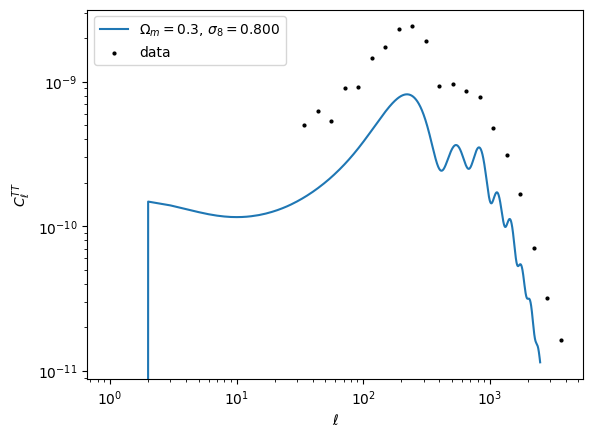

In [17]:
# Exemplo de cosmologia
# NOTE: o fator ell*(ell+1)/(2*pi) é apenas para fins de visualização
ell, clTT = get_cmb_cl(Omega_m=0.3, sigma_8=0.800)
plt.loglog(ell, ell*(ell+1)*clTT/(2*np.pi), label=f"$\\Omega_m = 0.3$, $\\sigma_8 = 0.800$")
plt.scatter(data_ell, data_ell*(data_ell+1)*data_clTT/(2*np.pi), s=4, color="black", label="data")
plt.legend()
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell^{TT}$")

In [ ]:
# Solução:
from random import uniform
from time import time
class MCMCWalker:
    """
        Helper class for managing MCMCs. The class contains methods for performing Monte Carlo steps and saves the state.
    """
    def __init__(self):
        # Hard-coding an initial point based on the exploration
        initial_om = 0.2
        initial_sigma8 = 0.880
        initial_params = [initial_om, initial_sigma8]
        initial_chi2 = chi2(initial_params)
        initial_sample = {
            'params': initial_params,
            'chi2': initial_chi2,
            'weight': 1,
        }
        self.samples = [initial_sample]

    def accept_sample(self, params, chi2):
        sample = {
            'params': params,
            'chi2': chi2,
            'weight': 1
        }
        self.samples.append(sample)

    def step(self):
        while True:
            current_chi2 = self.samples[-1]['chi2']
            new_om = self.samples[-1]['params'][0] + uniform(-0.25, 0.25)
            new_s8 = self.samples[-1]['params'][0] + uniform(-0.1, 0.1)
            
            new_params = [new_om, new_s8]
            if new_om < 0 or new_om > 1 or new_s8 > 1.5 or new_s8 < 0.4:
                # Reject point outside the prior
                self.samples[-1]['weight'] += 1
                continue
            new_chi2 = chi2(new_params)
            if new_chi2 == np.nan:
                # Reject points that have problematic chi2
                self.samples[-1]['weight'] += 1
                continue
            if new_chi2 < current_chi2:
                self.accept_sample(new_params, new_chi2)
                break
            else:
                r = uniform(0, 1)
                if r < np.exp(-(new_chi2 - current_chi2)/2):
                    self.accept_sample(new_params, new_chi2)
                    break
                else:
                    self.samples[-1]['weight'] += 1 # Increment weight
                    continue
    
    def gelman_rubin(self, n_split):
        all_params = np.array(
            [sample['params'] for sample in self.samples]
        )[:-(len(self.samples)%n_split)]
        np.random.shuffle(all_params)
        split_params = np.split(all_params, n_split)
        avg = np.mean(split_params, axis=1)
        std = np.std(split_params, axis=1)
        avg_of_std = np.mean(std, axis=0)
        std_of_avg = np.std(avg, axis=0)
        R_minus_one = std_of_avg/avg_of_std
        return np.max(R_minus_one)

def run_mcmc():
  w = MCMCWalker()
  print("Starting MCMC")
  start = time()
  while True:
      for _ in range(1000): w.step()
      R_minus_one = w.gelman_rubin(4)
      print(f"At {len(w.samples)} samples, R-1 = {R_minus_one}")
      if R_minus_one < 0.03: break 
  print(f"MCMC Converged! Took {time() - start:.2f} seconds")
  return w